- Xray energy is from 30-200 Kev (Ref. Method for filling and sharpening false color layers of dual energy x-ray images)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from glob import glob
import numpy as np
from color_image import ColorImage
from xraydb import material_mu
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image as Im

In [4]:
def get_voxels(stl_file, voxel_resolution = 300, rotation = 180):
    ci = ColorImage(stl_file, voxel_resolution=voxel_resolution)
    ci.rotate([0.5, 0, 0], rotation)
    ci.generate_voxels()
    return ci.voxels

def get_image(stl_file, voxel_resolution = 300, rotation = 180, axis = 2):
    return np.sum(ci.voxels, axis=axis)

In [5]:
def plot_data(data, cmap = 'GnBu'):
    plt.figure(figsize=(15, 10))
    im = plt.imshow(data, cmap=cmap)
    plt.axis('off')
    plt.show()

In [6]:
def subplot(data, cmap = "GnBu_r"):
    fig, axs = plt.subplots(3, figsize = (15, 15))
    axs[0].imshow(data[0], cmap = cmap)
    axs[0].axis('off')
    axs[1].imshow(data[1], cmap = cmap)
    axs[1].axis('off')
    axs[2].imshow(data[2], cmap = cmap)
    axs[2].axis('off')
    plt.show()

In [7]:
def get_xray_image(energy = 1e5):
    thickness_factor = 10
    l1_width = np.sum(stack_handgun, axis = 2) / thickness_factor
    l1_xray = np.ones_like(l1_width)
    m1 = material_mu('Fe', energy)
    l2_xray = np.multiply(l1_xray, np.exp(-m1 * l1_width))

    l2_width = np.sum(stack_knife, axis = 2) / thickness_factor
    m2 = material_mu('Al', energy)
    l3_xray = np.multiply(l2_xray, np.exp(-m2 * l2_width))

    l3_width = np.sum(stack_mouse, axis = 2) / thickness_factor
    m3 = material_mu('C', energy)
    l4_xray = np.multiply(l3_xray, np.exp(-m3 * l3_width))
    
    return l4_xray
#     return np.log(np.true_divide(l4_xray, l1_xray)), l4_xray 

In [8]:
# door_handle, handgun, knife, mouse, shuriken
stl_files = "../stl_files/"
stack = get_voxels(stl_files + "handgun_knife_mouse.stl")
stack = stack.astype('float')
stack_handgun = stack[:, :, :30]
stack_knife = stack[:, :, 30:64]
stack_mouse = stack[:, :, 64:]

In [ ]:
stack.shape

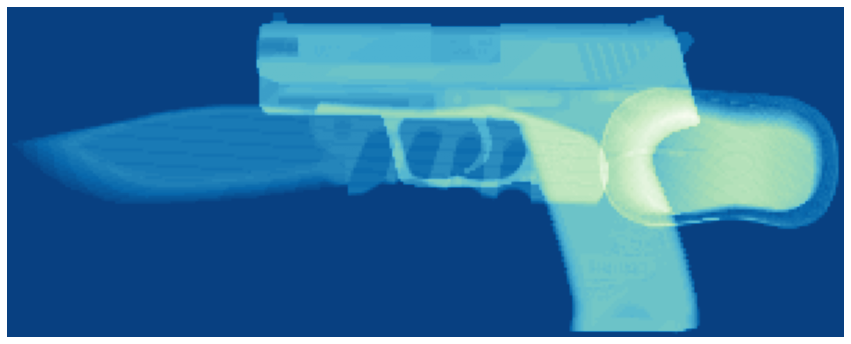

In [9]:
plot_data(np.sum(stack, axis = 2), cmap = "GnBu_r")

In [10]:
# le = get_xray_image(energy = 1e5)
# me = get_xray_image(energy = 3e5)
# he = get_xray_image(energy = 5e5)

# Helix Pseudocolor Algorithm

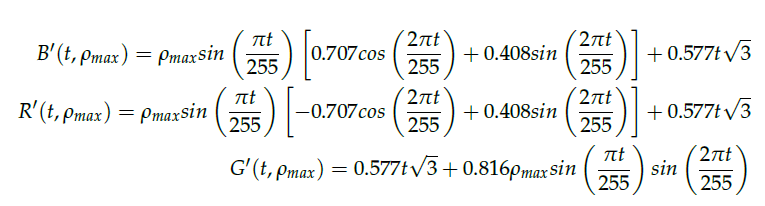

In [12]:
from IPython.display import Image
Image("images/HPC_equations.png")

Where 
- $t$ = Brightness [0, 255] and 
-images/o_{max}$ = Color saturation [0, 140] (0 gives grayscale values, 140 is the most saturateed color and the recommended value)

In [13]:
def hpc(img, rho):
    assert len(img.shape) == 2
    img = np.array(img)
    blue = rho * np.sin(np.pi * img / 255.) * (0.707 * np.cos(2 * np.pi * img / 255.) + 0.408 * np.sin(2 * np.pi * img / 255.)) + 0.577 * img * np.sqrt(3)
    red = rho * np.sin(np.pi * img / 255.) * ( - 0.707 * np.cos(2 * np.pi * img / 255.) + 0.408 * np.sin(2 * np.pi * img / 255.)) + 0.577 * img * np.sqrt(3)
    green = 0.577 * img * np.sqrt(3) + 0.816 * rho * np.sin(np.pi * img / 255.) * np.sin(2 * np.pi * img / 255.)
    rgb =  np.dstack((red, green, blue))
    return np.array(rgb / rgb.max() * 255, dtype = np.uint8)

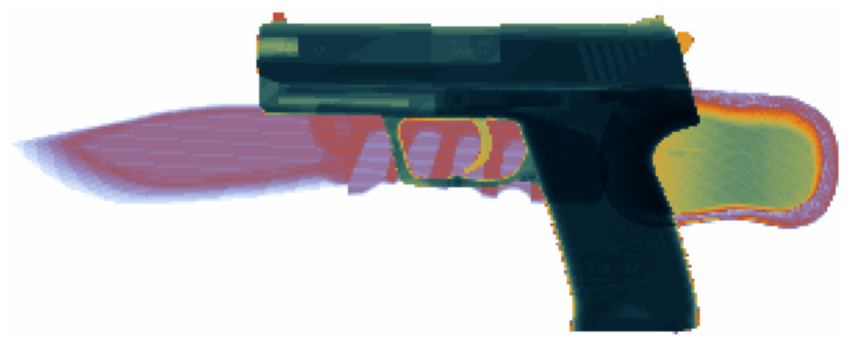

In [14]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 2e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.uint8)

plot_data(hpc(xray_gray, 140))

# Linear Mapping

- Reference: Abidi, B. R., Zheng, Y., Gribok, A. V., & Abidi, M. A. (2006). Improving weapon detection in single energy X-ray images through pseudocoloring. IEEE Transactions on Systems, Man and Cybernetics Part C: Applications and Reviews, 36(6), 784–796. https://doi.org/10.1109/TSMCC.2005.855523

## a) Hot

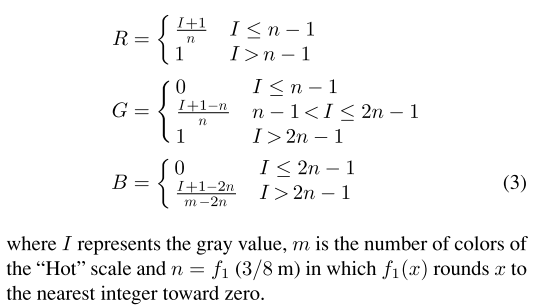

In [15]:
Image("images/linear_mapping_cmap_hot.png")

## b) Jet

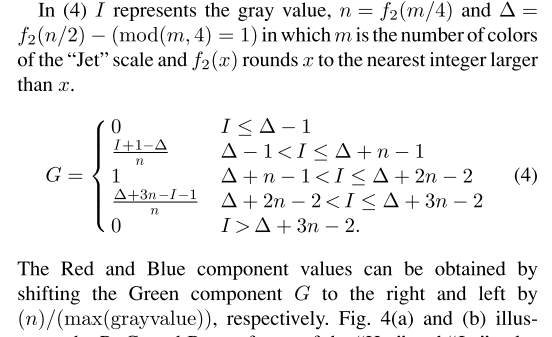

In [16]:
Image("images/linear_mapping_cmap_jet.png")

In [18]:
def linear_mapping(img, m = 8, cmap = 'hot'):
    img = np.array(img)
    
    if cmap == 'hot':
        n = np.floor(3. / 8. * m)
    
        red = (img + 1) / n
        red[img > n-1] = 1

        green = (img + 1 - n) / n
        green[img <= n - 1] = 0
        green[img > 2 * n - 1] = 1

        blue = (img + 1 - 2 * n) / (m - 2 * n)
        blue[img <= 2 * n - 1] = 0

        rgb =  np.dstack((red, green, blue))
        return np.array(rgb / rgb.max() * 255, dtype = np.uint8)
    elif cmap == 'jet':
        n = np.ceil(m / 4.)
        delta = np.ceil(n / 2.) - np.mod(m, 4)
        
        green = np.zeros_like(img)
        green[(delta - 1. < img) & (img <= delta + n - 1)] = (img[(delta - 1. < img) & (img <= delta + n - 1)] + 1. - delta) / n
        green[(delta + n - 1 < img) & (img <= delta + 2.*n -2.)] = 1.
        green[(delta + 2. * n - 2 < img) & (img <= delta + 3. * n -2)] = (delta + 3.*n - img[(delta + 2. * n - 2. < img) & (img <= delta + 3 * n -2)] - 1.) / n
        
        red = green + (n / img.max())
        blue = green - (n / img.max())
        
        rgb = np.dstack((red, green, blue))
        return np.array(rgb / rgb.max() * 255., dtype = np.uint8)

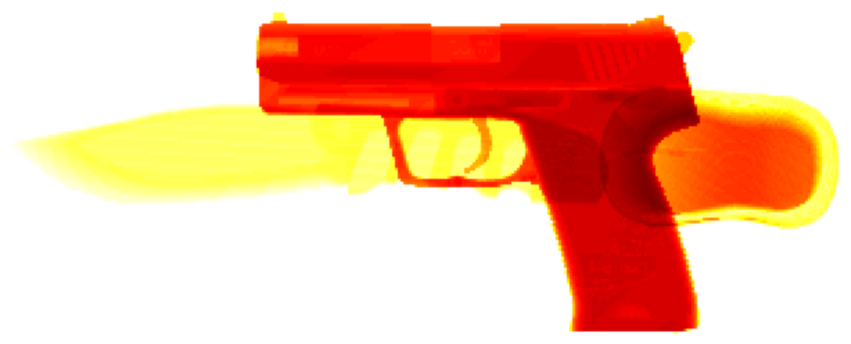

In [19]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 8e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(linear_mapping(xray_gray, m = 256, cmap = 'hot'))

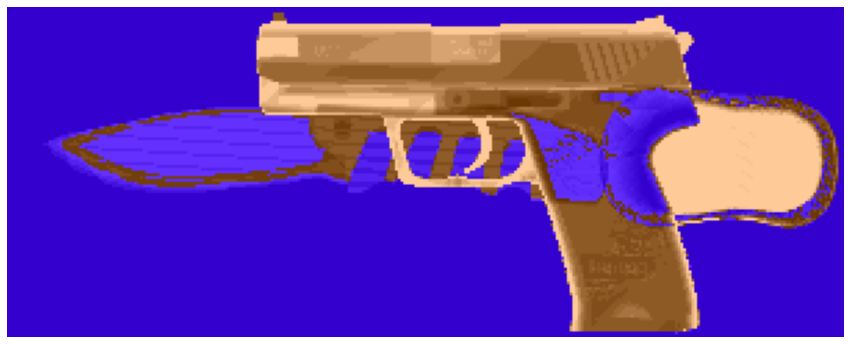

In [20]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 5e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(linear_mapping(xray_gray, m = 256, cmap = 'jet'))

# Non-linear Mapping
## Springtime

In [21]:
import math

In [22]:
def f1(I,S): # I(1-S)
    return np.multiply(I, np.subtract(1,S))

def f2(I,S,H): # I[1+(ScosH/cos(60-H))]
    r = math.pi/180
    a = np.multiply(S, np.cos(r*H)) # ScosH
    b = np.cos(r*np.subtract(60,H)) # cos(60-H)
    return np.multiply(I, np.add(1, np.divide(a,b)) )

def f3(I,C1,C2): # 3I-(C1+C2)
    return np.subtract(3*I, np.add(C1,C2))

def hsi_to_rgb(H, S, I):
    zmax = 255 # max value

    R,G,B = np.ones(H.shape),np.ones(H.shape),np.ones(H.shape) # values will be between [0,1]
    # for 0 <= H < 120
    B[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    # for 120 <= H < 240
    H = np.subtract(H,120)
    R[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], G[(0<=H)&(H<120)])

    # for 240 <= H < 360
    H = np.subtract(H,120)
    G[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], G[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    rgb = np.dstack( (zmax*R , zmax*G , zmax*B) )
    rgb = np.array(rgb / rgb.max() * 255, np.uint8) # values between [0,255]
    return rgb

In [23]:
def spring_time(img):
    img = np.array(img)
    g_max = 255.
    h = 0.5 - 0.5 * np.sqrt(1 - (img / g_max) ** 2)
    h = h / h.max() * 360
    s = 0.8 * np.ones_like(img, dtype=np.float32)
    i = np.log((img + 1.) / (g_max + 1.))
    
    print(h.max(), s.max(), i.max())
    
    return hsi_to_rgb(h, s, i)

360.0 0.8 0.0


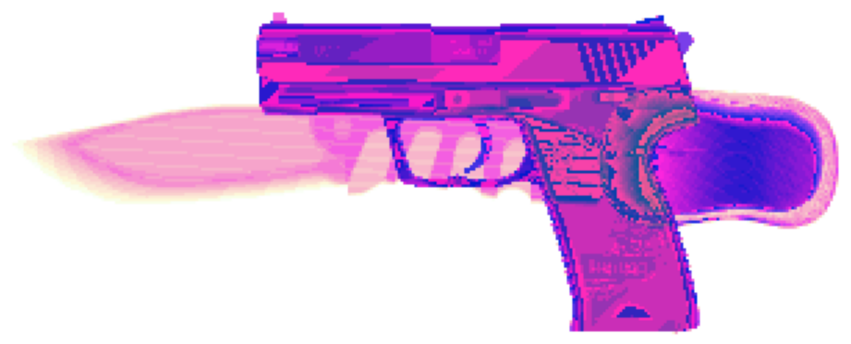

In [24]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 5e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(spring_time(xray_gray))

### Testing the code with a sample image from sixray dataset

In [25]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [38]:
sample_img = Im.open("images/N0000058.jpg")
sample_img_ar = np.array(sample_img)
sample_gray = rgb2gray(sample_img_ar)

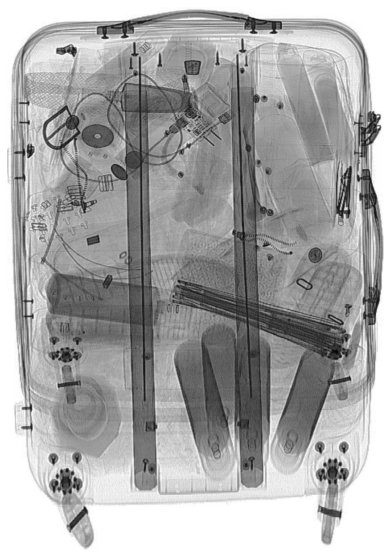

In [39]:
plot_data(sample_gray, cmap = 'gray')

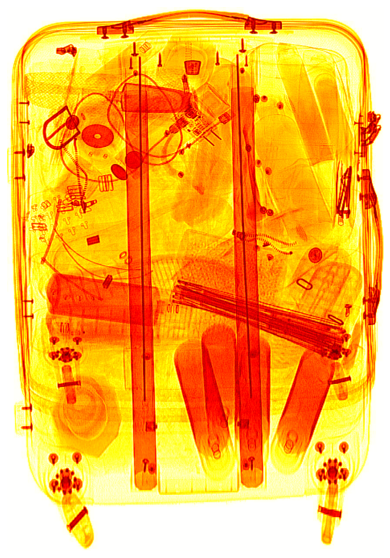

In [40]:
plot_data(linear_mapping(sample_gray, m = 256, cmap = 'hot'))

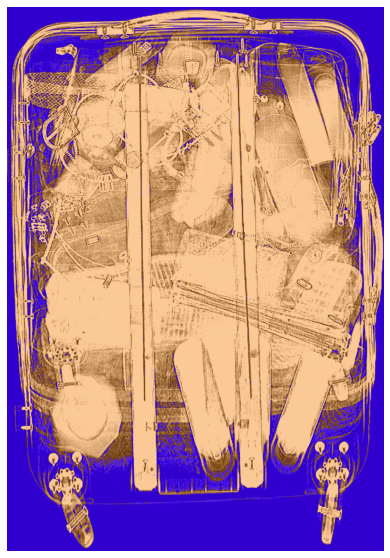

In [41]:
plot_data(linear_mapping(sample_gray, m = 256, cmap = 'jet'))

360.0 0.8 -9.961433634334793e-05


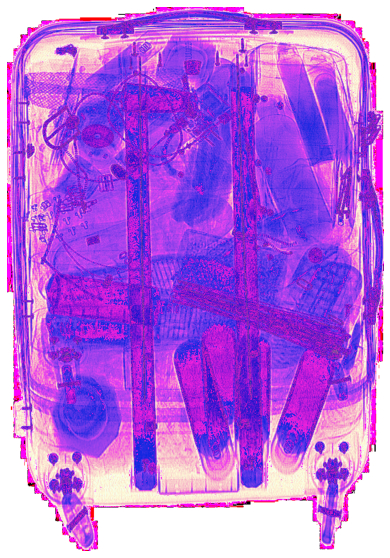

In [42]:
plot_data(spring_time(sample_gray))

In [43]:
# for i in range(0, 150, 10):
#     print('rho: ' + str(i))
#     xray_img = hpc(xray_gray, i)
#     plot_data(xray_img)

In [44]:
plot_data(le - me)

NameError: name 'le' is not defined

In [34]:
plot_data(me - le)

NameError: name 'me' is not defined

In [35]:
# for en in range(10000, 900000, 10000):
#     print(en)
#     plot_data(get_xray_image(energy = en), cmap="GnBu_r")

In [36]:
plt.figure(figsize=(15, 10))
plt.imshow(le, cmap = "GnBu_r")

NameError: name 'le' is not defined

<Figure size 1080x720 with 0 Axes>

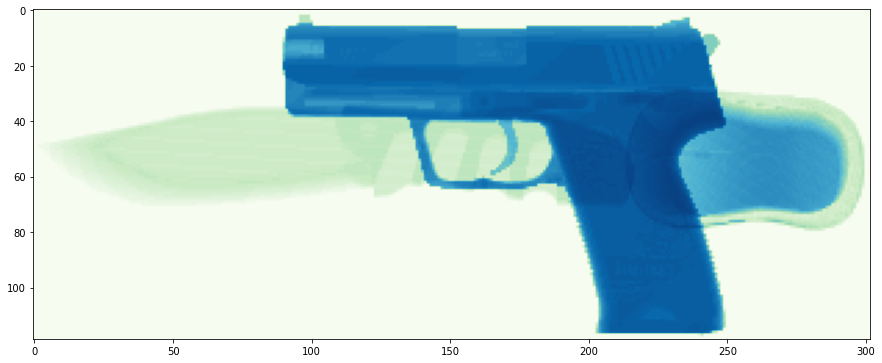

In [19]:
plt.figure(figsize=(15, 10))
plt.imshow(me, cmap = "GnBu_r")

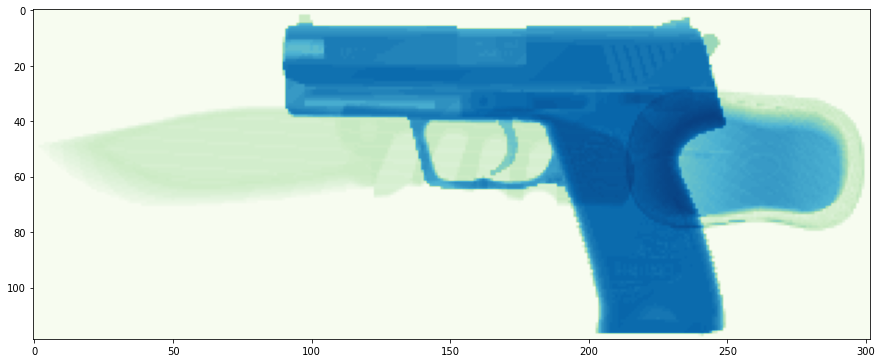

In [20]:
plt.figure(figsize=(15, 10))
plt.imshow(he, cmap = "GnBu_r")

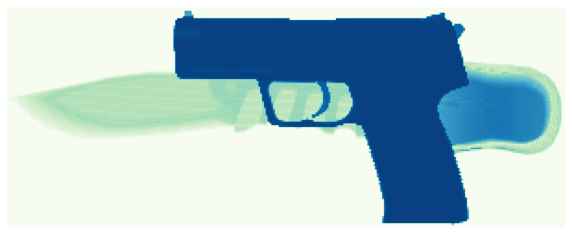

In [21]:
plot_data(le, cmap = "GnBu_r")

In [37]:
plot_data(me, cmap = "GnBu_r")

NameError: name 'me' is not defined

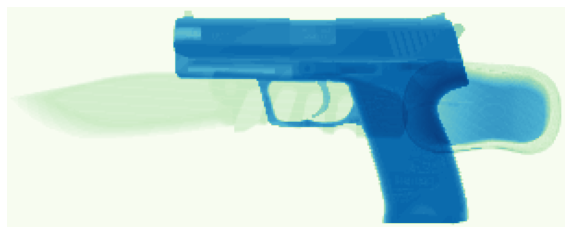

In [23]:
plot_data(he, cmap = "GnBu_r")

In [24]:
red = np.abs(le - me)
green = np.abs(me - he)
blue = np.abs(he - le)

In [25]:
img = np.dstack((red, green, blue))
img.shape

(119, 302, 3)

(array([19377.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        16561.]),
 array([0.        , 0.11764706, 0.23529412, 0.35294118, 0.47058824,
        0.58823529, 0.70588235, 0.82352941, 0.94117647, 1.05882353,
        1.17647059, 1.29411765, 1.41176471, 1.52941176, 1.64705882,
        1.76470588, 1.88235294, 2.        ]),
 <BarContainer object of 17 artists>)

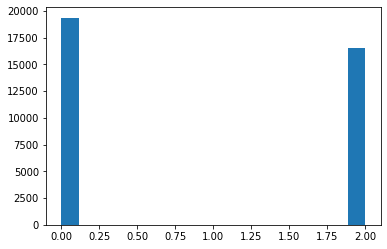

In [26]:
plt.hist(np.argmax(img, axis = 2).flatten(), bins = 'auto')

Looks like Red and Blue are dominant

In [27]:
np.max(red), np.max(green), np.max(blue)

(0.4223612632876755, 0.09782911209094619, 0.49998381871202274)

(array([19602.,  1268.,  6418.,  4714.,  1886.,   865.,   529.,   410.,
          128.,   118.]),
 array([0.        , 0.04223613, 0.08447225, 0.12670838, 0.16894451,
        0.21118063, 0.25341676, 0.29565288, 0.33788901, 0.38012514,
        0.42236126]),
 <BarContainer object of 10 artists>)

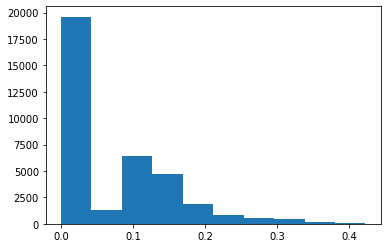

In [28]:
plt.hist(red.flatten())

(array([19440.,   466.,   359.,  2848.,  1556.,   353.,   737.,  2840.,
         3808.,  3531.]),
 array([0.        , 0.00978291, 0.01956582, 0.02934873, 0.03913164,
        0.04891456, 0.05869747, 0.06848038, 0.07826329, 0.0880462 ,
        0.09782911]),
 <BarContainer object of 10 artists>)

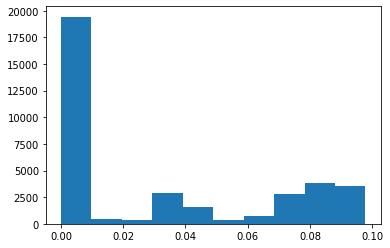

In [29]:
plt.hist(green.flatten())

(array([19594.,   536.,  2236.,  5663.,  3978.,  1876.,   896.,   534.,
          480.,   145.]),
 array([0.        , 0.04999838, 0.09999676, 0.14999515, 0.19999353,
        0.24999191, 0.29999029, 0.34998867, 0.39998705, 0.44998544,
        0.49998382]),
 <BarContainer object of 10 artists>)

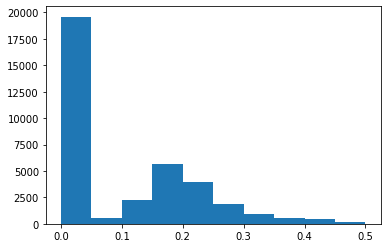

In [30]:
plt.hist(blue.flatten())

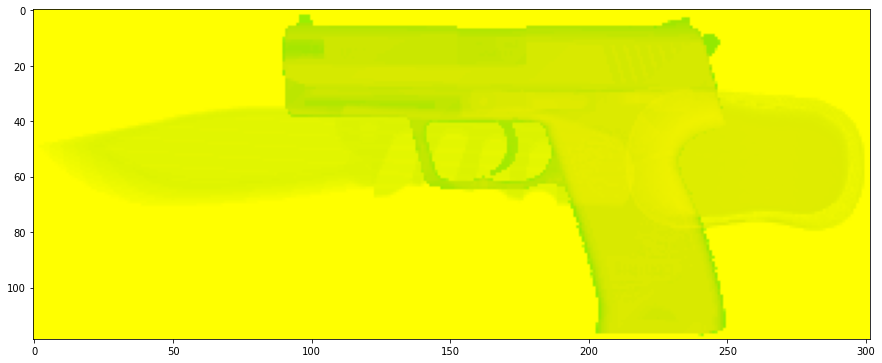

In [31]:
ximage = np.dstack((1. - red, 1. - green, np.zeros_like(red, dtype = np.float32)))
plt.figure(figsize = (15, 10))
plt.imshow(ximage)
plt.show()

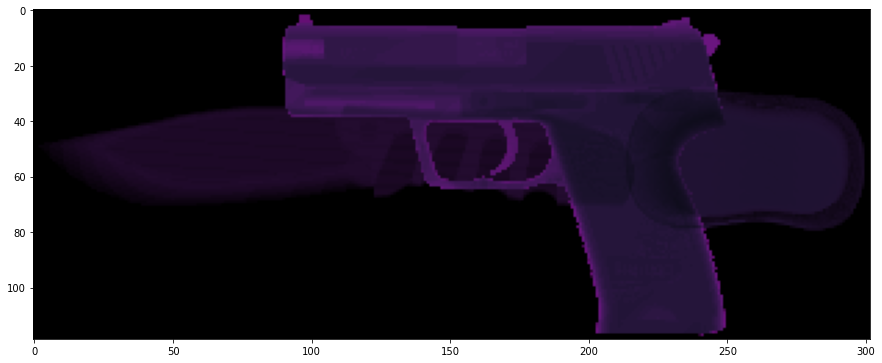

In [32]:
ximage = np.dstack((red, green, blue))
plt.figure(figsize=(15, 10))
plt.imshow(ximage, plt.cm.GnBu)
plt.savefig('rgb.png')

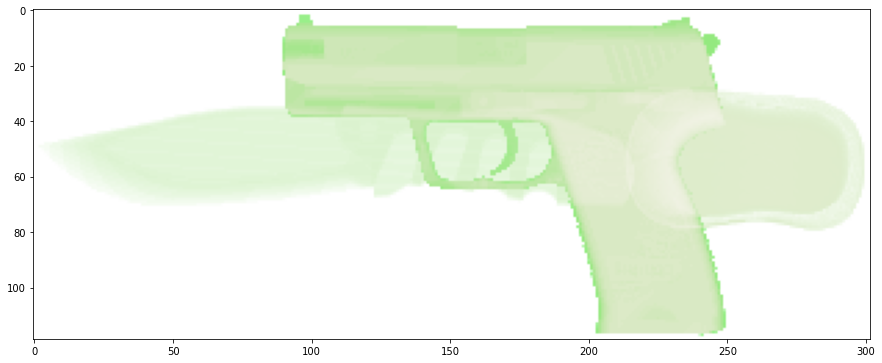

In [33]:
ximage = np.dstack((1. - red, 1. - green, 1. - blue))
plt.figure(figsize=(15, 10))
plt.imshow(ximage, plt.cm.GnBu)
plt.savefig('rgb.png')

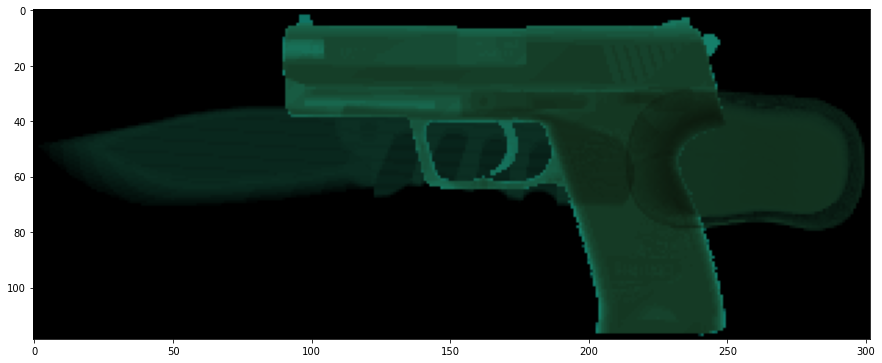

In [34]:
ximage = np.dstack((green, blue, red))
plt.figure(figsize=(15, 10))
plt.imshow(ximage)
plt.savefig('gbr.png')

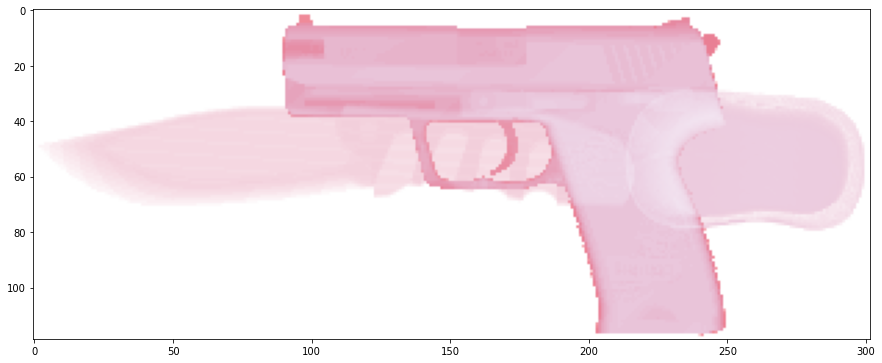

In [35]:
ximage = np.dstack((1. - green, 1. - blue, 1. - red))
plt.figure(figsize=(15, 10))
plt.imshow(ximage)
plt.savefig('gbr.png')

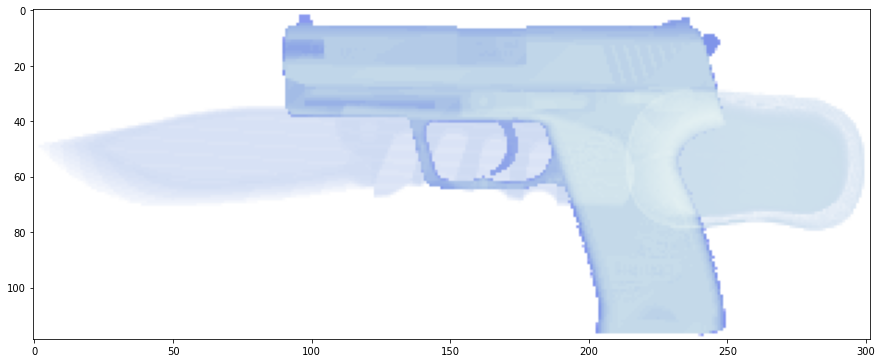

In [36]:
ximage = np.dstack((1. - blue, 1. - red, 1. - green))
plt.figure(figsize=(15, 10))
plt.imshow(ximage)
plt.savefig('brg.png')

In [37]:
plt.imshow(ximage_uint8[..., 0])

NameError: name 'ximage_uint8' is not defined

In [ ]:
plt.imshow(ximage_uint8[..., 1])

In [ ]:
plt.imshow(ximage_uint8[..., 2])

In [ ]:
Image.fromarray(np.dstack((bird_ar[..., 0], bird_ar[..., 2], bird_ar[..., 1])))

In [ ]:
bird = Image.open('bird.jpg')
bird

In [ ]:
bird_ar = np.array(bird)
bird_ar.shape

In [ ]:
plt.imshow(bird_ar[..., 0]/255.0)

In [ ]:
plt.imshow(bird_ar[..., 1]/255.0)

In [ ]:
plt.imshow(bird_ar[..., 2]/255.0)

In [ ]:
bird_ar[..., 0]

In [ ]:
from PIL import Image

def to_rgb(rgb):
    rgbArray = np.zeros(rgb.shape, 'uint8')
    rgbArray[..., 0] = r*256
    rgbArray[..., 1] = g*256
    rgbArray[..., 2] = b*256
    img = Image.fromarray(rgbArray)
    img.save('myimg.jpeg')

According the ref. on the top of the page
- $Q = \frac{logI_{LE}}{logI_{HE}}$
1. Metal 1.02 - 1.15
2. Plastic 1.005 - 1.02
3. Organic 0972 - 1.005

In [ ]:
cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
len(cmaps)

In [ ]:
log_he, he = get_xray_image(2e5)
log_le, le = get_xray_image(1e5)

In [ ]:
def plot_with_colormaps(cmaps, imagename):
    fig, axs = plt.subplots(len(cmaps), 2, figsize = (100, 100))
    for i, c in enumerate(cmaps):
        axs[i, 0].imshow(np.divide(log_le, log_he), cmap = c); axs[i, 0].axis('off'); axs[i, 0].set_title(c)
        axs[i, 1].imshow(np.abs(np.subtract(log_le, log_he)), cmap = c); axs[i, 1].axis('off'); axs[i, 1].set_title(c)

    fig.tight_layout()
    plt.savefig(imagename, dpi = 50)
    plt.close()
#     plt.show()

In [ ]:
for i in range(0, len(cmaps), 6):
    plot_with_colormaps(cmaps[i:i+6], "images/colormaps/" + "_".join(cmaps[i:i+6]) + ".png")
#     break

In [ ]:
le = l2_xray/l1_xray

In [ ]:
he = l2_xray/l1_xray

In [ ]:
q = np.divide(le, he)

In [ ]:
q

In [ ]:
plt.hist(q.flatten(), bins = 'auto')
plt.show()

In [ ]:
plt.hist(le.flatten(), bins = np.linspace(0.1, 0.9, 9))
plt.show()

In [ ]:
plt.hist(he.flatten(), bins = np.linspace(0.1, 0.9, 9))
plt.show()

In [ ]:
plot_data(l2_xray, cmap = "GnBu_r")

In [ ]:
plt.hist(l3_xray.flatten(), bins = 'auto')
plt.show()

In [ ]:
stack_handgun

Identify the individual objects by separating the layers <br>
- Right now the layer boundary is hardcoded. Write a program that autmatically detects the boundaries

In [ ]:
i0 = 3e5
m1 =  material_mu('Fe', i0)
i1 = i0 * np.exp(-m1/10 * 20)
print(i1)
m2 = material_mu('Fe', i1)
i2 = i1 * np.exp(-m2/10 * 30)
print(i2)
i = i0 * np.exp(-m1/10 * 50)
print(i)

In [ ]:
layers = np.zeros(stack.shape[2])
for i in range(stack.shape[2]):
    layers[i] = np.sum(stack[:, :, i]) != 0

In [ ]:
# Assign mu values to the corresponding voxels
# Material mu returns absorption length in 1/cm
xray_energies = [40e3, 50e3, 60e3]
fe_mu = [material_mu('Fe', energy) for energy in xray_energies]
# al_mu = [material_mu('Al', energy) for energy in xray_energies]

xfactor = 100

In [ ]:
stack_handgun_ex_factor = [np.sum(stack_handgun, axis = 2)[:, :, np.newaxis]/xfactor * m for m in fe_mu] # (119, 302, 1)
# stack_knife_ex_factor = [np.sum(stack_knife, axis = 2)[:, :, np.newaxis]/xfactor * m for m in al_mu]

In [ ]:
def get_mu(x):
    shape = x.shape
    x = x.flatten()
    mu = np.array([material_mu('Al', i) for i in x.tolist()])
    return mu.reshape(shape)

In [ ]:
import multiprocessing as mp

In [ ]:
pool = mp.Pool(mp.cpu_count())
def get_al_mu(x):
    return material_mu('Al', x)
results = pool.map(get_al_mu, np.arange(100))

In [ ]:
intensity_first_layer = [en * np.exp(-ef) for (en, ef) in zip(xray_energies, stack_handgun_ex_factor)]

In [ ]:
# second_layer_mu = [material_mu('Al', x) for i in intensity_first_layer for x in i.flatten()]
second_layer_mu = [get_mu(x) for x in intensity_first_layer]

In [ ]:
stack_knife_ex_factor = [np.sum(stack_knife, axis = 2)[:, :, np.newaxis]/xfactor * m for m in second_layer_mu]

In [ ]:
intensity_second_layer = [(np.multiply(i, np.exp(-j))) for (i, j) in zip(intensity_first_layer, stack_knife_ex_factor)]

In [ ]:
subplot(intensity_second_layer)

In [ ]:
stack_handguns = [np.sum(stack_handgun, axis = 2)[:, :, np.newaxis] * m for m in fe_mu]
stack_knifes = [np.sum(stack_knife, axis = 2)[:, :, np.newaxis] * m for m in al_mu]
# merge the layers
stack_total_xray = [np.concatenate((i, j), axis = 2)/10 for (i, j) in zip(stack_handguns, stack_knifes)] # for different energies

In [ ]:
np.exp()

In [ ]:
stack_xray_image = [np.exp(-m/100 * )]

In [ ]:
stack_handgun_xray = [np.exp(-m / 100 * np.sum(stack_handgun, axis = 2)[:, :, np.newaxis]) for m in fe_mu]
stack_knife_xray = [np.exp(-m / 100 * np.sum(stack_knife, axis = 2)[:, :, np.newaxis]) for m in al_mu]

In [ ]:
stack_handgun_xray = [np.exp(-m / 100 * np.sum(stack_handgun, axis = 2)[:, :, np.newaxis]) for m in fe_mu]
stack_knife_xray = [np.exp(-m / 100 * np.sum(stack_knife, axis = 2)[:, :, np.newaxis]) for m in al_mu]

In [ ]:
subplot(stack_handgun_xray)

In [ ]:
subplot(stack_knife_xray)

In [ ]:
plot_data(np.concatenate(stack_handgun_xray, axis = 2), cmap = "GnBu_r")

In [ ]:
plot_data(np.concatenate(stack_knife_xray, axis = 2), cmap = "GnBu_r")

In [ ]:
fig, axs = plt.subplots(3, figsize = (10, 5))
axs[0].hist(stack_handgun_xray[0].flatten(), bins='auto')
axs[1].hist(stack_handgun_xray[1].flatten(), bins='auto')
axs[2].hist(stack_handgun_xray[2].flatten(), bins='auto')
plt.show()

In [ ]:
plt.hist(np.concatenate(stack_handgun_xray, axis = 2).flatten(), bins='auto')
plt.show()

In [ ]:
fe_mu

In [ ]:
al_mu

In [ ]:
# Assign mu values to the corresponding voxels
fe_mu = [material_mu('Fe', energy) for energy in [10e3, 100e3, 800e3]]
al_mu = [material_mu('Al', energy) for energy in [10e3, 100e3, 800e3]]
stack1, stack2, stack3 = stack.copy(), stack.copy(), stack.copy()
tf = 100 # thinkness factor
stack1[np.nonzero(stack1[:, :, :30])] = fe_mu[0]
stack1[np.nonzero(stack1[:, :, 30:64])] = al_mu[0]
stack1[np.nonzero(stack1[:, :, :64])] = stack1[np.nonzero(stack1[:, :, :64])] / tf

stack2[np.nonzero(stack2[:, :, :30])] = fe_mu[1]
stack2[np.nonzero(stack2[:, :, 30:64])] = al_mu[1]
stack2[np.nonzero(stack2[:, :, :64])] = stack2[np.nonzero(stack2[:, :, :64])] / tf

stack3[np.nonzero(stack3[:, :, :30])] = fe_mu[2]
stack3[np.nonzero(stack3[:, :, 30:64])] = al_mu[2]
stack3[np.nonzero(stack3[:, :, :64])] = stack3[np.nonzero(stack3[:, :, :64])] / tf

In [ ]:
stacks = [stack1, stack2, stack3]
stacks_images_diff_energies = [np.sum(s[:, :, :64], axis = 2) for s in stacks]

In [ ]:
# apply x-ray absorption
stacks_xray_images = [np.exp(-vim) for vim in stacks_images_diff_energies]

In [ ]:
plot_data(stacks_images_diff_energies[0])

In [ ]:
plot_data(stacks_images_diff_energies[1])

In [ ]:
plot_data(stacks_images_diff_energies[2])

Now, take the difference of the values in energy-dependent images

In [ ]:
first = np.abs(stacks_images_diff_energies[0] - stacks_images_diff_energies[1])[:, :, np.newaxis]
first = first/np.max(first)
second = np.abs(stacks_images_diff_energies[1] - stacks_images_diff_energies[2])[:, :, np.newaxis]
second = second/np.max(second)
third = np.abs(stacks_images_diff_energies[2] - stacks_images_diff_energies[0])[:, :, np.newaxis]
third = third/np.max(third)

In [ ]:
plot_data(first)

In [ ]:
plot_data(second)

In [ ]:
plot_data(third)

In [ ]:
rgb_image = np.concatenate((first, second, third), axis = 2); rgb_image.shape

In [ ]:
plot_data(rgb_image[:, :, 1])

In [ ]:
plot_data(np.sum(rgb_image, axis = 2), cmap='GnBu')

In [ ]:
rgb_image[20:50, 100:150, 0]*255

In [ ]:
from matplotlib import cm

In [ ]:
rgb_image2 = np.uint8(rgb_image * 255)

In [ ]:
Image.fromarray(rgb_image2, 'RGB')

In [ ]:
rgb_image_2.getchannel()

In [ ]:
# Image.fromarray(np.uint8(np.concatenate((first, second, third), axis = 2))*255).convert('RGB')

In [ ]:
im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

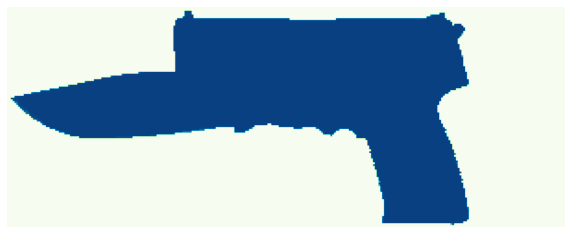

In [106]:
plot_data(stacks_xray_images[0]/np.max(stacks_xray_images[0]))

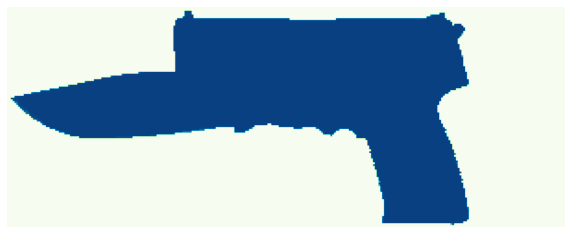

In [107]:
plot_data(stacks_xray_images[1]/np.max(stacks_xray_images[1]))

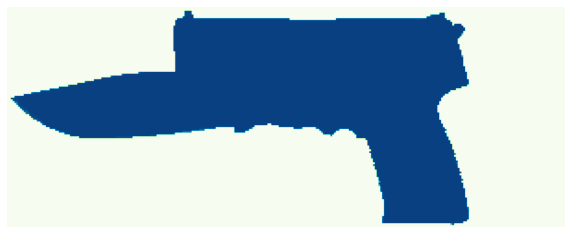

In [108]:
plot_data(stacks_xray_images[2]/np.max(stacks_xray_images[2]))

In [95]:
handgun_img = np.sum(handgun, axis = 2)
mouse_img = np.sum(mouse, axis = 0)
stack_img = np.sum(stack, axis = 2)
knife_img = np.sum(knife, axis = 0)
handgun_img.shape, mouse_img.shape, stack_img.shape, knife_img.shape

((216, 302), (302, 302), (119, 302), (302, 302))

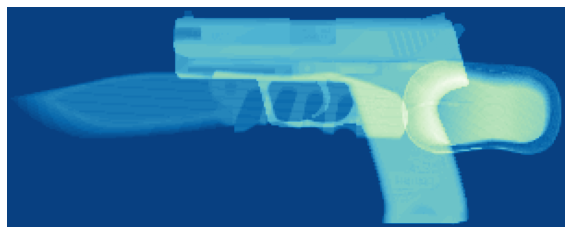

In [102]:
plot_data(stack_img)

In [61]:
def get_xray(voxel_image, material = 'Fe'):
    mu = [material_mu(material, energy) for energy in [10e3, 100e3, 800e3]]
    trans = [np.exp(- (voxel_image / 100 ) * m)[:, :, np.newaxis] for m in mu]
    return np.concatenate(trans, axis = 2)

In [103]:
mouse_img.shape

(302, 302)

In [104]:
mouse_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [98]:
handgun_xray = get_xray(handgun_img, material='Fe')
mouse_xray = get_xray(mouse_img, material='C')
knife_xray = get_xray(knife_img, material='Fe')

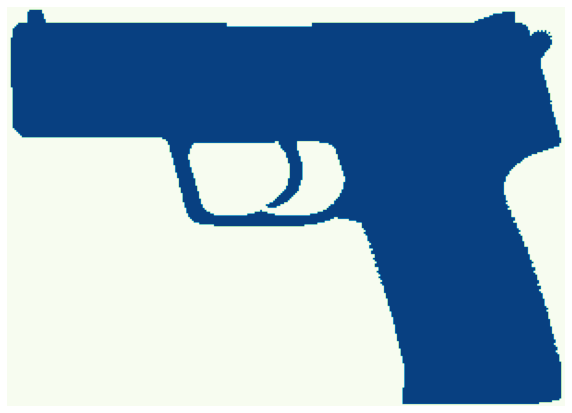

In [97]:
plot_data(handgun_xray[:, :, 0])

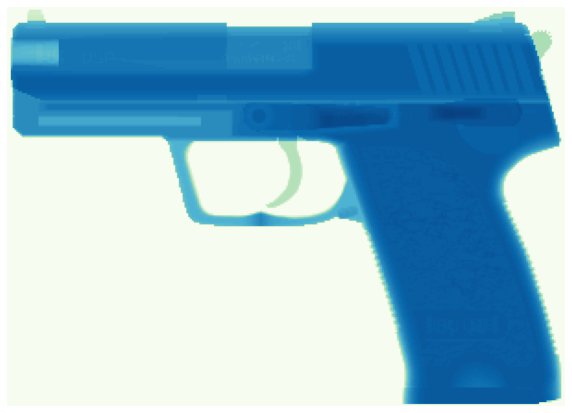

In [64]:
plot_data(handgun_xray[:, :, 1])

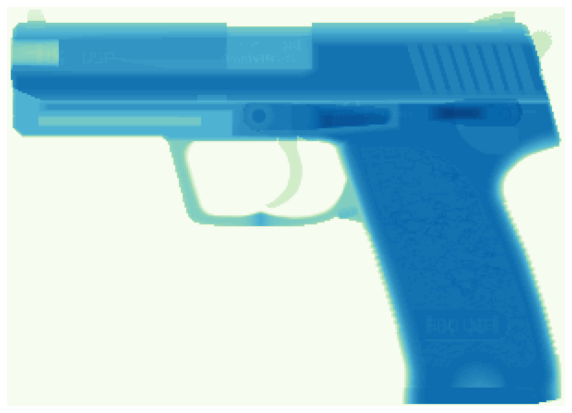

In [65]:
plot_data(handgun_xray[:, :, 2])

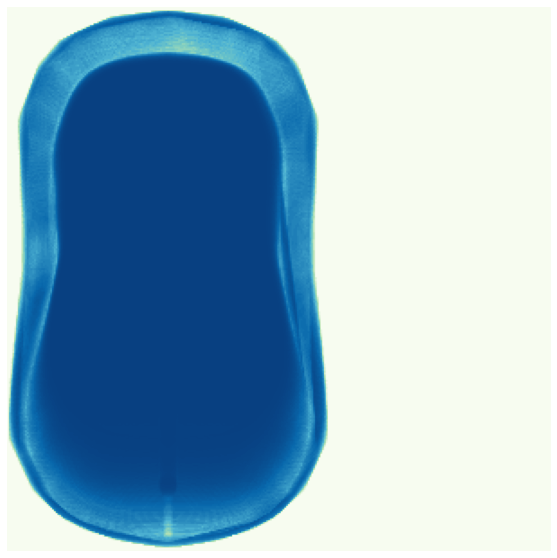

In [66]:
plot_data(mouse_xray[:, :, 0])

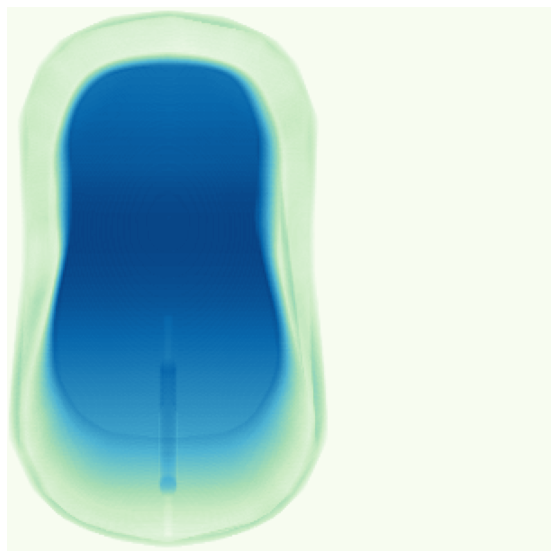

In [67]:
plot_data(mouse_xray[:, :, 1])

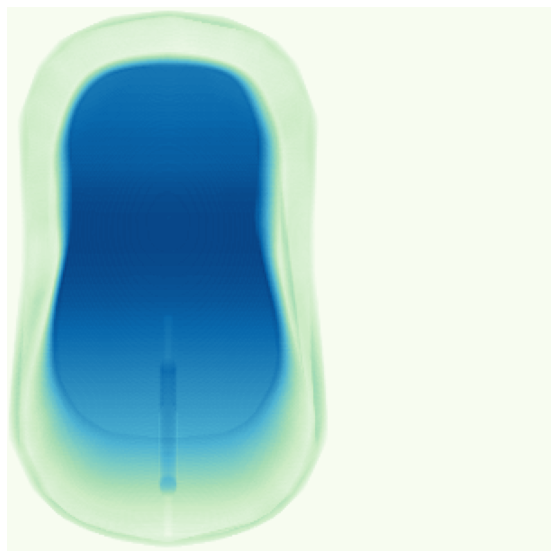

In [68]:
plot_data(mouse_xray[:, :, 2])

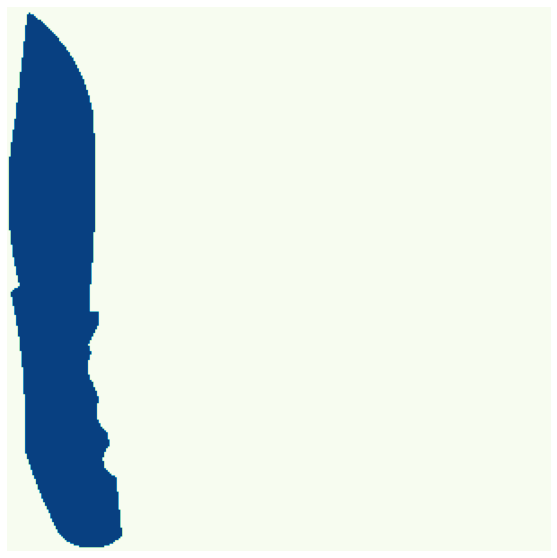

In [99]:
plot_data(knife_xray[:, :, 0])

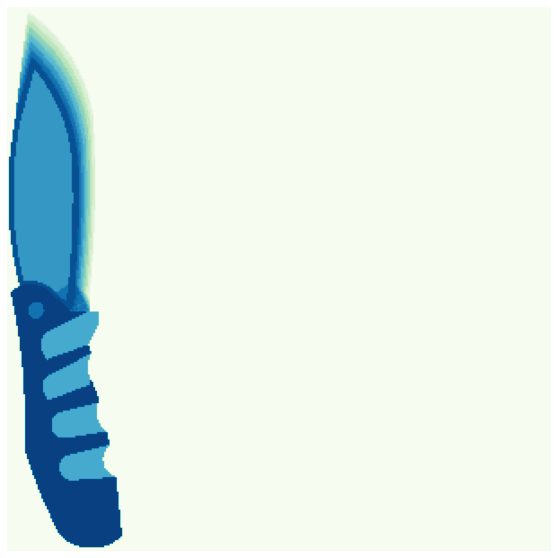

In [100]:
plot_data(knife_xray[:, :, 1])

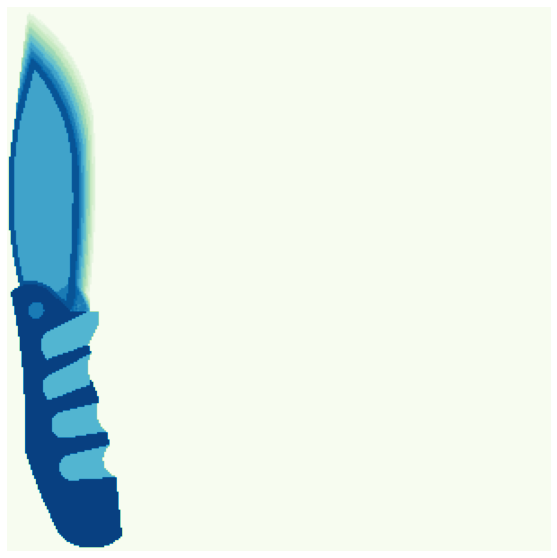

In [101]:
plot_data(knife_xray[:, :, 2])

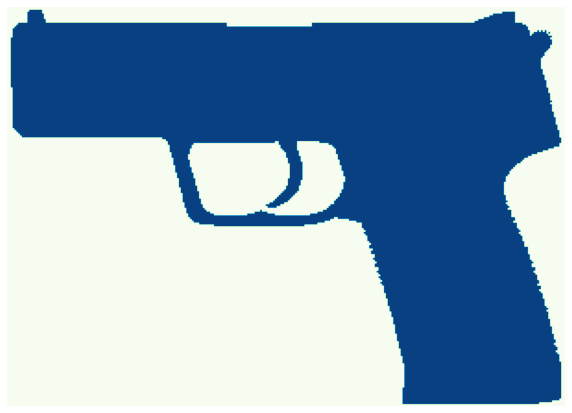

In [347]:
im = Image.fromarray(np.uint8(xray_image[:, :, 1:3]) * 255).convert('RGB')
im_g = im.convert('L')
plot_data(im_g, cmap = "GnBu_r")

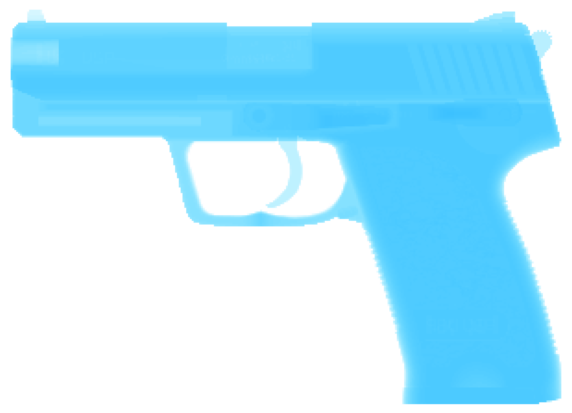

In [298]:
xray_image_3 = np.concatenate((xray_image[:, :, 1][:, :, np.newaxis], xray_image[:, :, 2][:, :, np.newaxis], np.ones_like(xray_image[:, :, 0:1])), axis = 2)
plot_data(xray_image_3, cmap = "GnBu_r")

In [8]:
calsteps = get_img("stl_files/5mm_Calibration_Steps.stl")

an error has occured at x0z299.0
an error has occured at x1z299.0
an error has occured at x2z299.0
an error has occured at x3z299.0
an error has occured at x4z299.0
an error has occured at x5z299.0
an error has occured at x6z299.0
an error has occured at x7z299.0
an error has occured at x8z299.0
an error has occured at x9z299.0
an error has occured at x10z299.0
an error has occured at x11z299.0
an error has occured at x12z299.0
an error has occured at x13z299.0
an error has occured at x14z299.0
an error has occured at x15z299.0
an error has occured at x16z299.0
an error has occured at x17z299.0
an error has occured at x18z299.0
an error has occured at x19z299.0
an error has occured at x20z299.0
an error has occured at x21z299.0
an error has occured at x22z299.0
an error has occured at x23z299.0
an error has occured at x24z299.0
an error has occured at x25z299.0
an error has occured at x26z299.0
an error has occured at x27z299.0
an error has occured at x28z299.0
an error has occured at 

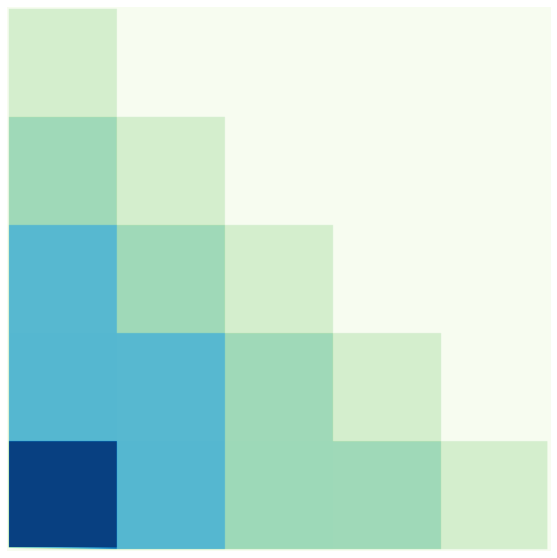

In [9]:
plot_data(calsteps, cmap = "GnBu")

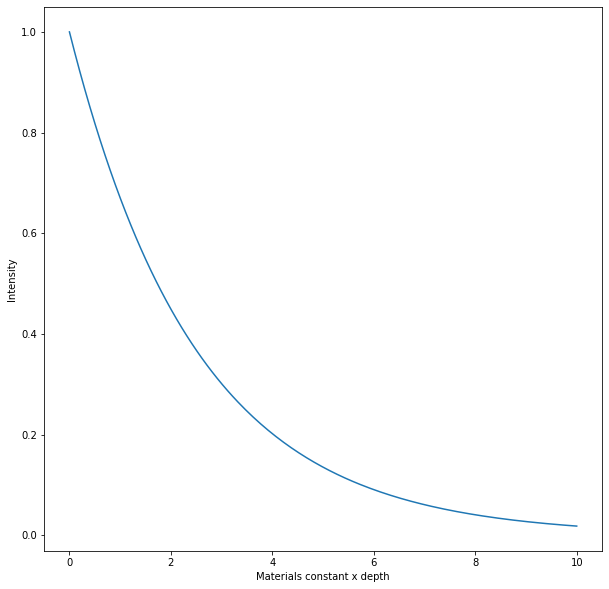

In [58]:
# x = np.linspace(0, 10, 200)
# y = 1.0 * np.exp(-1 * 0.4 * x)
# plt.figure(figsize=(10, 10))
# plt.xlabel("Materials constant x depth")
# plt.ylabel("Intensity")
# plt.plot(x, y)
# plt.show()

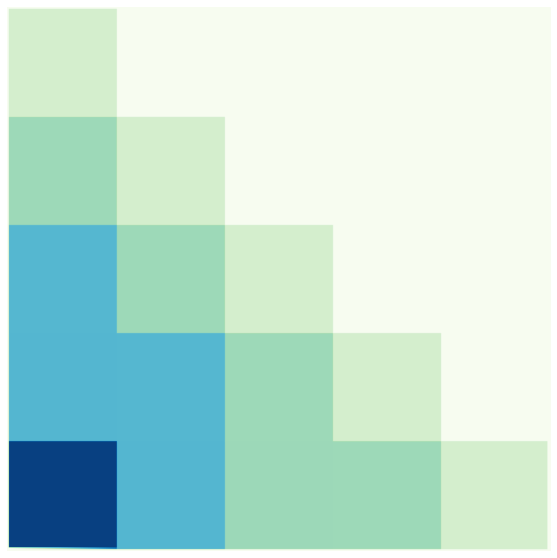

In [54]:
plot_data(np.exp(-1. * 0.0001 * calsteps), cmap = "GnBu_r")

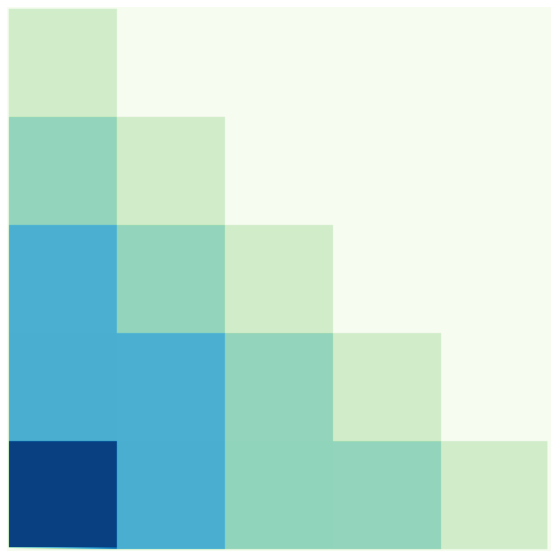

In [55]:
plot_data(np.exp(-1. * 0.001 * calsteps), cmap = "GnBu_r")

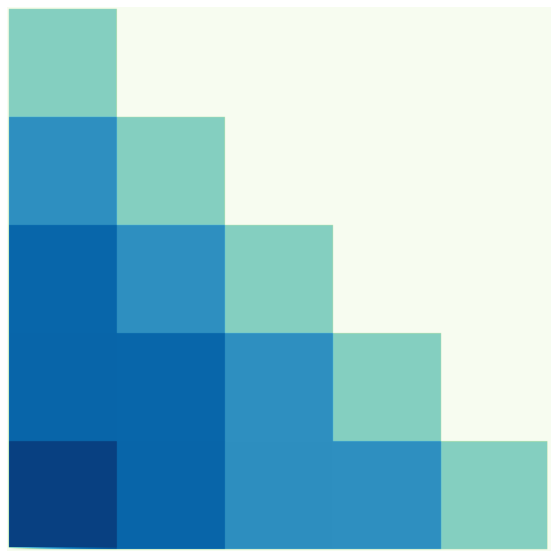

In [56]:
plot_data(np.exp(-1. * 0.01 * calsteps), cmap = "GnBu_r")

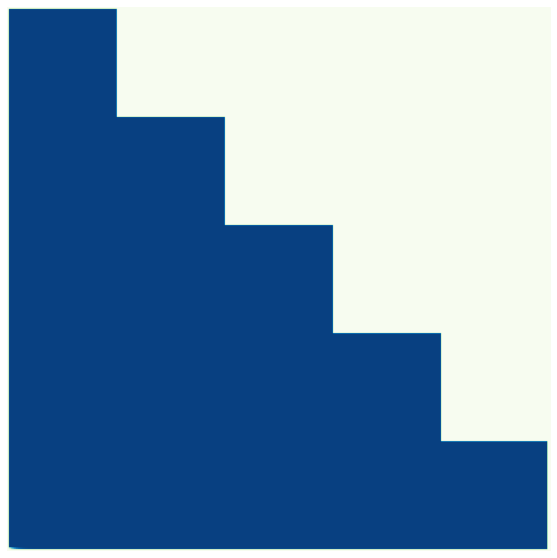

In [57]:
plot_data(np.exp(-1. * 0.1 * calsteps), cmap = "GnBu_r")

In [16]:
z1 = np.exp(-1. * 0.01 * calsteps)
z2 = np.exp(-1. * 0.0001 * calsteps)

In [347]:
import cv2

In [350]:
cv2.imshow("m", z1)

In [341]:
imz = np.concatenate((z1[:, :, np.newaxis], z2[:, :, np.newaxis]), axis=2)
imz.shape

(302, 302, 2)

TypeError: Invalid shape (302, 302, 2) for image data

<Figure size 432x288 with 0 Axes>

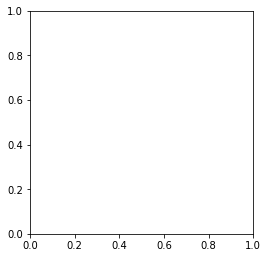

In [345]:
imz /= 255.0
plt.figure()
plt.matshow(imz)
plt.show()

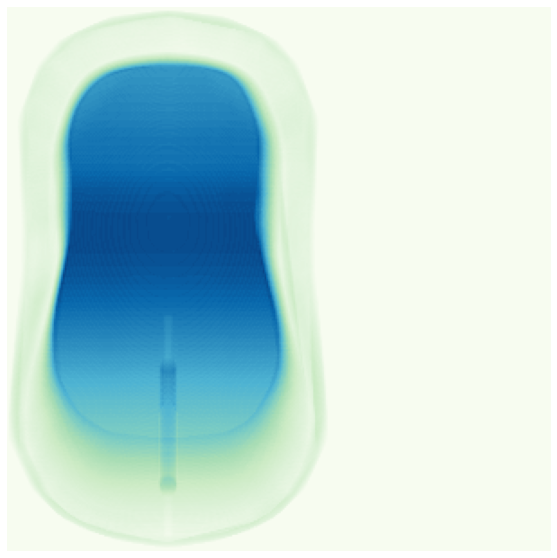

In [219]:
mouse11 = 1.0 * np.exp(1.0 * 0.01 * mouse1)
plot_data(mouse11, cmap = "GnBu")

In [186]:
ch1 = 1.0 * np.exp(1.0 * 0.01 * xray_volume)
ch2 = 50.0 * np.exp(1.0 * 0.01 * xray_volume)

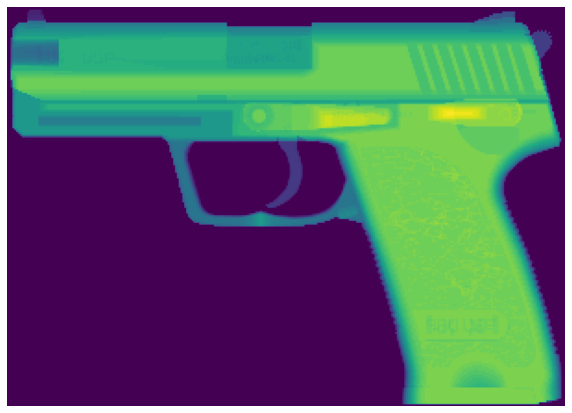

In [187]:
plot_data(ch1, cmap='viridis')

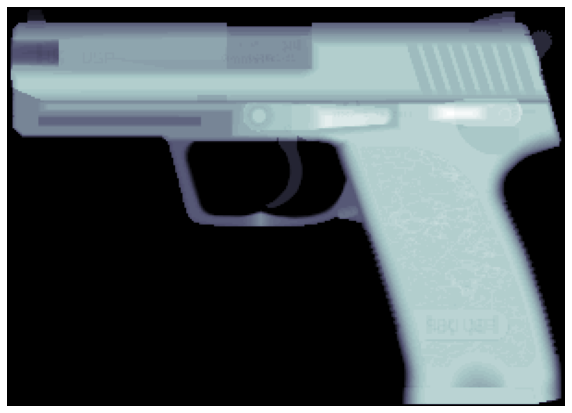

In [190]:
plot_data(ch2, cmap='bone')

In [191]:
np.max(ch1), np.max(ch2)

(1.632316219955379, 81.61581099776895)

In [192]:
ch1 = (ch1 / np.max(ch1)) / 255.0
ch2 = (ch2 / np.max(ch2)) / 255.0

In [193]:
img_2ch = np.concatenate((ch1[:, :, np.newaxis], ch2[:, :, np.newaxis]), axis=2)
img = np.mean(img_2ch, axis=2)
img.shape

(216, 302)

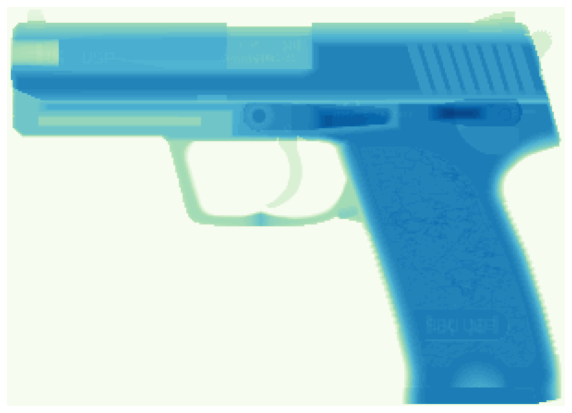

In [194]:
plot_data(img, cmap = "GnBu")

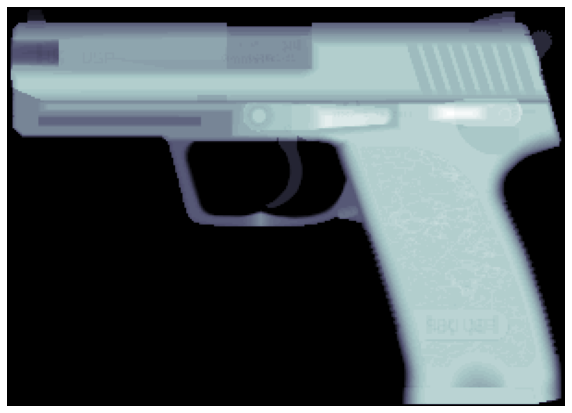

In [195]:
plot_data(ch1, cmap = "bone")

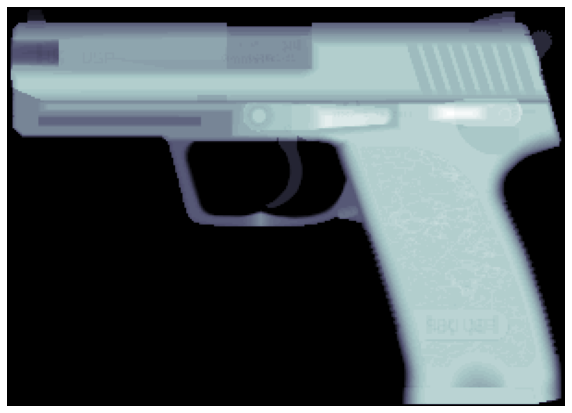

In [196]:
plot_data(ch2, cmap = "bone")

In [125]:
from PIL import Image

In [133]:
im = np.array(Image.open("images/N0000001.jpg"))
im.shape

(1387, 1291, 3)

In [134]:
im[:, :, 0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [135]:
np.min(im[:, :, 0])

0

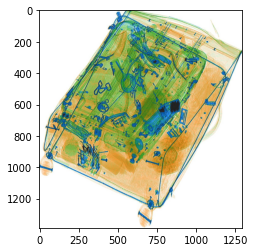

In [136]:
plt.imshow(im)